Target CRS set from raster: EPSG:2056
 51872 unique NFI plot locations.
Remaining records: 15516
Prepared 4063 unique NFI plot points for mapping.
Successfully loaded and reprojected Swiss border shapefile.
Plotted raster basemap.
Plotted country border.
Plotted 4063 NFI points.

Map saved to ../figures/nfi_ch2018/NFI_Plots_Map_Switzerland.png


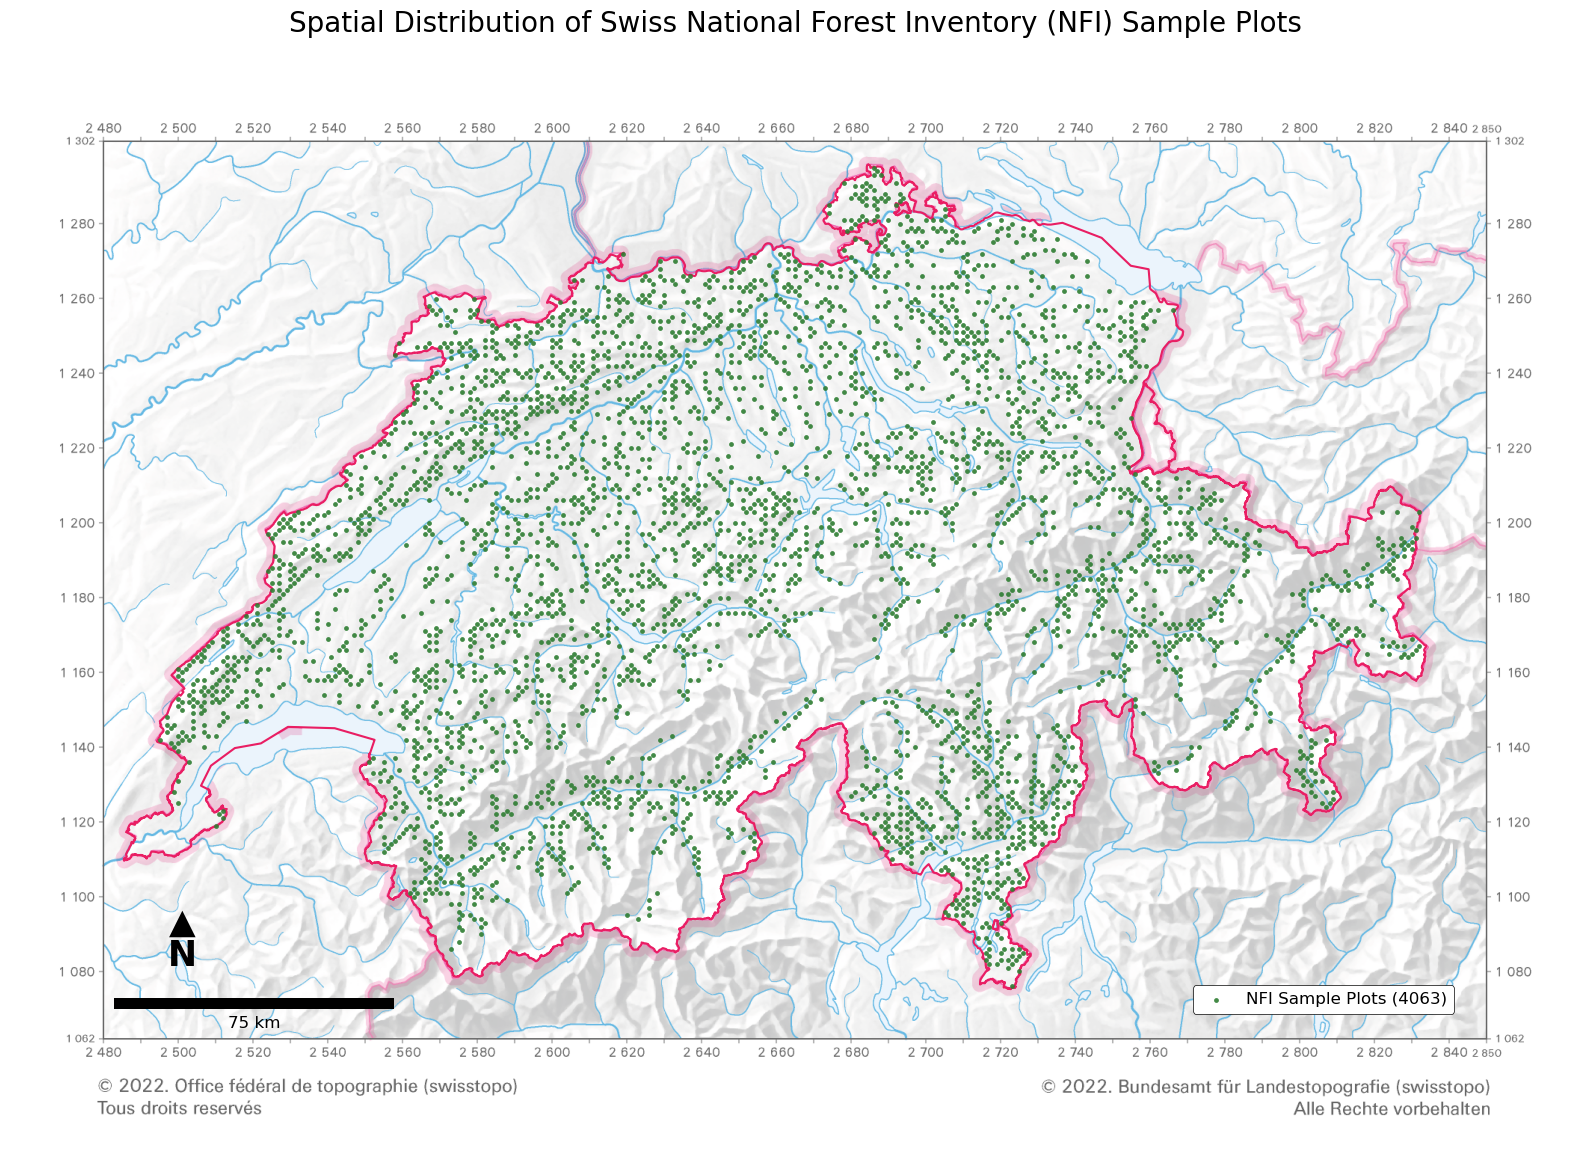

In [1]:
# Imports and Configuration
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show as raster_show
# For adding a scale bar
from matplotlib_scalebar.scalebar import ScaleBar

# --- Configuration ---
NFI_CSV_PATH = "../data/preprocessed/final_nfi_ch2018_merged/NFI_with_Climate_Averages_RCP45.csv"
RASTER_BASEMAP_PATH = "../data/raw/map_data/CH_Relief_2Mio.tif"

SWISS_BORDER_SHP_PATH = "../data/raw/map_data/swissboundaries3d_2025-04_2056_5728.shp" 

OUTPUT_FILE_PATH = "../figures/nfi_ch2018/NFI_Plots_Map_Switzerland.png"

# --- Determine Target CRS from Raster Basemap ---
TARGET_CRS_EPSG = None
with rasterio.open(RASTER_BASEMAP_PATH) as src:
    TARGET_CRS_EPSG = src.crs.to_epsg()
print(f"Target CRS set from raster: EPSG:{TARGET_CRS_EPSG}")

# --- Load and Prepare NFI Plot Data ---
nfi_df = pd.read_csv(NFI_CSV_PATH, encoding='utf-8')
print(f" {len(nfi_df)} unique NFI plot locations.")

nfi_df = nfi_df[nfi_df['BASFPH'] <= 100].copy()
nfi_df = nfi_df[nfi_df['BASFPH_next_INVNR'] <= 100].copy()

print(f"Remaining records: {len(nfi_df)}")

unique_plots_data = nfi_df.dropna(subset=['X', 'Y']).drop_duplicates(subset='CLNR', keep='first').copy()
geometry_nfi = [Point(xy) for xy in zip(unique_plots_data['X'], unique_plots_data['Y'])]
gdf_nfi_plots = gpd.GeoDataFrame(
    unique_plots_data, geometry=geometry_nfi, crs="EPSG:21781"
)
gdf_nfi_plots = gdf_nfi_plots.to_crs(epsg=TARGET_CRS_EPSG) # Reproject

print(f"Prepared {len(gdf_nfi_plots['CLNR'].unique())} unique NFI plot points for mapping.")

# --- Load and Prepare Swiss Border Data ---
try:
    gdf_border = gpd.read_file(SWISS_BORDER_SHP_PATH)
    gdf_border = gdf_border.to_crs(epsg=TARGET_CRS_EPSG) # Reproject
    print("Successfully loaded and reprojected Swiss border shapefile.")
except Exception as e:
    print(f"--- WARNING ---")
    print(f"Could not load the border shapefile from: {SWISS_BORDER_SHP_PATH}")
    print(f"Error: {e}")
    print("The map will be generated without the country border outline.")
    gdf_border = None


# --- Create the Map ---
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
fig.patch.set_facecolor('white')

# 1. Plot the Raster Basemap
with rasterio.open(RASTER_BASEMAP_PATH) as src:
    map_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    raster_show(src, ax=ax, cmap='gray', alpha=0.6, zorder=1) # Reduced alpha for softer look
    ax.set_xlim(map_extent[0], map_extent[1])
    ax.set_ylim(map_extent[2], map_extent[3])
print("Plotted raster basemap.")

# 2. Plot the Swiss Border Outline (if loaded)
if gdf_border is not None:
    gdf_border.plot(
        ax=ax,
        edgecolor='#E91E63', # A nice magenta/pink color like the reference
        facecolor='none',    # No fill color
        linewidth=1.5,
        zorder=3             # Draw on top of basemap but below points
    )
    print("Plotted country border.")

# 3. Plot all NFI Points with refined styling
gdf_nfi_plots.plot(
    ax=ax,
    marker='o',
    color='#2E7D32',      # A deep, clear green
    markersize=12,         # Smaller markers, closer to reference
    linewidth=0,          # No edge on the markers
    alpha=0.9,
    zorder=4,             # Highest layer
    label=f'NFI Sample Plots ({len(gdf_nfi_plots)})'
)
print(f"Plotted {len(gdf_nfi_plots)} NFI points.")

# 4. Add Cartographic Elements

# --- Scale Bar (Lower Left) ---
scalebar = ScaleBar(1, 'm', location='lower left', box_alpha=0.0,
                    bbox_to_anchor=(0.06, 0.113),
                    bbox_transform=ax.transAxes,
                    border_pad=0.5, color='black', font_properties={'size': 'large'})
ax.add_artist(scalebar)

# --- North Arrow (Lower Left, above Scale Bar) ---
ax.text(0.11, 0.19, 'N', fontsize=25, fontweight='bold', ha='center', va='center',
        transform=ax.transAxes, zorder=5)
ax.text(0.11, 0.22, '▲', fontsize=25, ha='center', va='center',
        transform=ax.transAxes, zorder=5)

# --- Legend (Lower Right) ---
legend = ax.legend(loc='lower right', bbox_to_anchor=(0.925, 0.13), frameon=True, facecolor='white', framealpha=1, fontsize='large')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)

# 5. Final Touches
ax.set_title('Spatial Distribution of Swiss National Forest Inventory (NFI) Sample Plots', fontsize=20, pad=20)
ax.set_axis_off() # This command removes all coordinates and axes
plt.tight_layout()

# 6. Save the Figure for Publication
plt.savefig(OUTPUT_FILE_PATH, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nMap saved to {OUTPUT_FILE_PATH}")

plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import os

# --- Professional Plotting Style ---
sns.set_theme(style="whitegrid", context="paper") # Use 'talk' or 'poster' for different contexts
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 300 # High resolution for saving

# --- Load Data ---
file_path = '../data/preprocessed/ch2018/CH2018_yearly_metrics.csv'
data = pd.read_csv(file_path)

OUTPUT_FILE_PATH = "../figures/nfi_ch2018/Projected_changes_climate_variables.png"

# --- Feature Engineering: Extract and Order RCP Scenario ---
# The RCP scenario is critical for analysis. We extract it from the simulation string.
def extract_rcp(simulation_string):
    if 'RCP26' in simulation_string or 'RCP2.6' in simulation_string:
        return 'RCP 2.6'
    elif 'RCP45' in simulation_string or 'RCP4.5' in simulation_string:
        return 'RCP 4.5'
    elif 'RCP85' in simulation_string or 'RCP8.5' in simulation_string:
        return 'RCP 8.5'
    return 'Unknown'

data['rcp'] = data['simulation'].apply(extract_rcp)

# Define a consistent order and color palette for scenarios
rcp_order = ['RCP 2.6', 'RCP 4.5', 'RCP 8.5']
rcp_palette = {'RCP 2.6': '#2c7fb8', 'RCP 4.5': '#fec44f', 'RCP 8.5': '#c51b8a'}

print("Data loaded and prepared for plotting.")

Data loaded and prepared for plotting.


/var/folders/8v/8ysgj2ts3wndnfw8s60082cw0000gn/T/ipykernel_94300/2650390793.py:9: FutureWarning: The provided callable <function median at 0x10a32d4e0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary_df = sim_avg.groupby(['year', 'rcp'])[variable].agg(
/var/folders/8v/8ysgj2ts3wndnfw8s60082cw0000gn/T/ipykernel_94300/2650390793.py:9: FutureWarning: The provided callable <function median at 0x10a32d4e0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary_df = sim_avg.groupby(['year', 'rcp'])[variable].agg(
/var/folders/8v/8ysgj2ts3wndnfw8s60082cw0000gn/T/ipykernel_94300/2650390793.py:9: FutureWarning: The provided callable <function median at 0x10a32d4e0> is currently using SeriesGroupBy.median. In a future version of pa


Map saved to ../figures/nfi_ch2018/Projected_changes_climate_variables.png


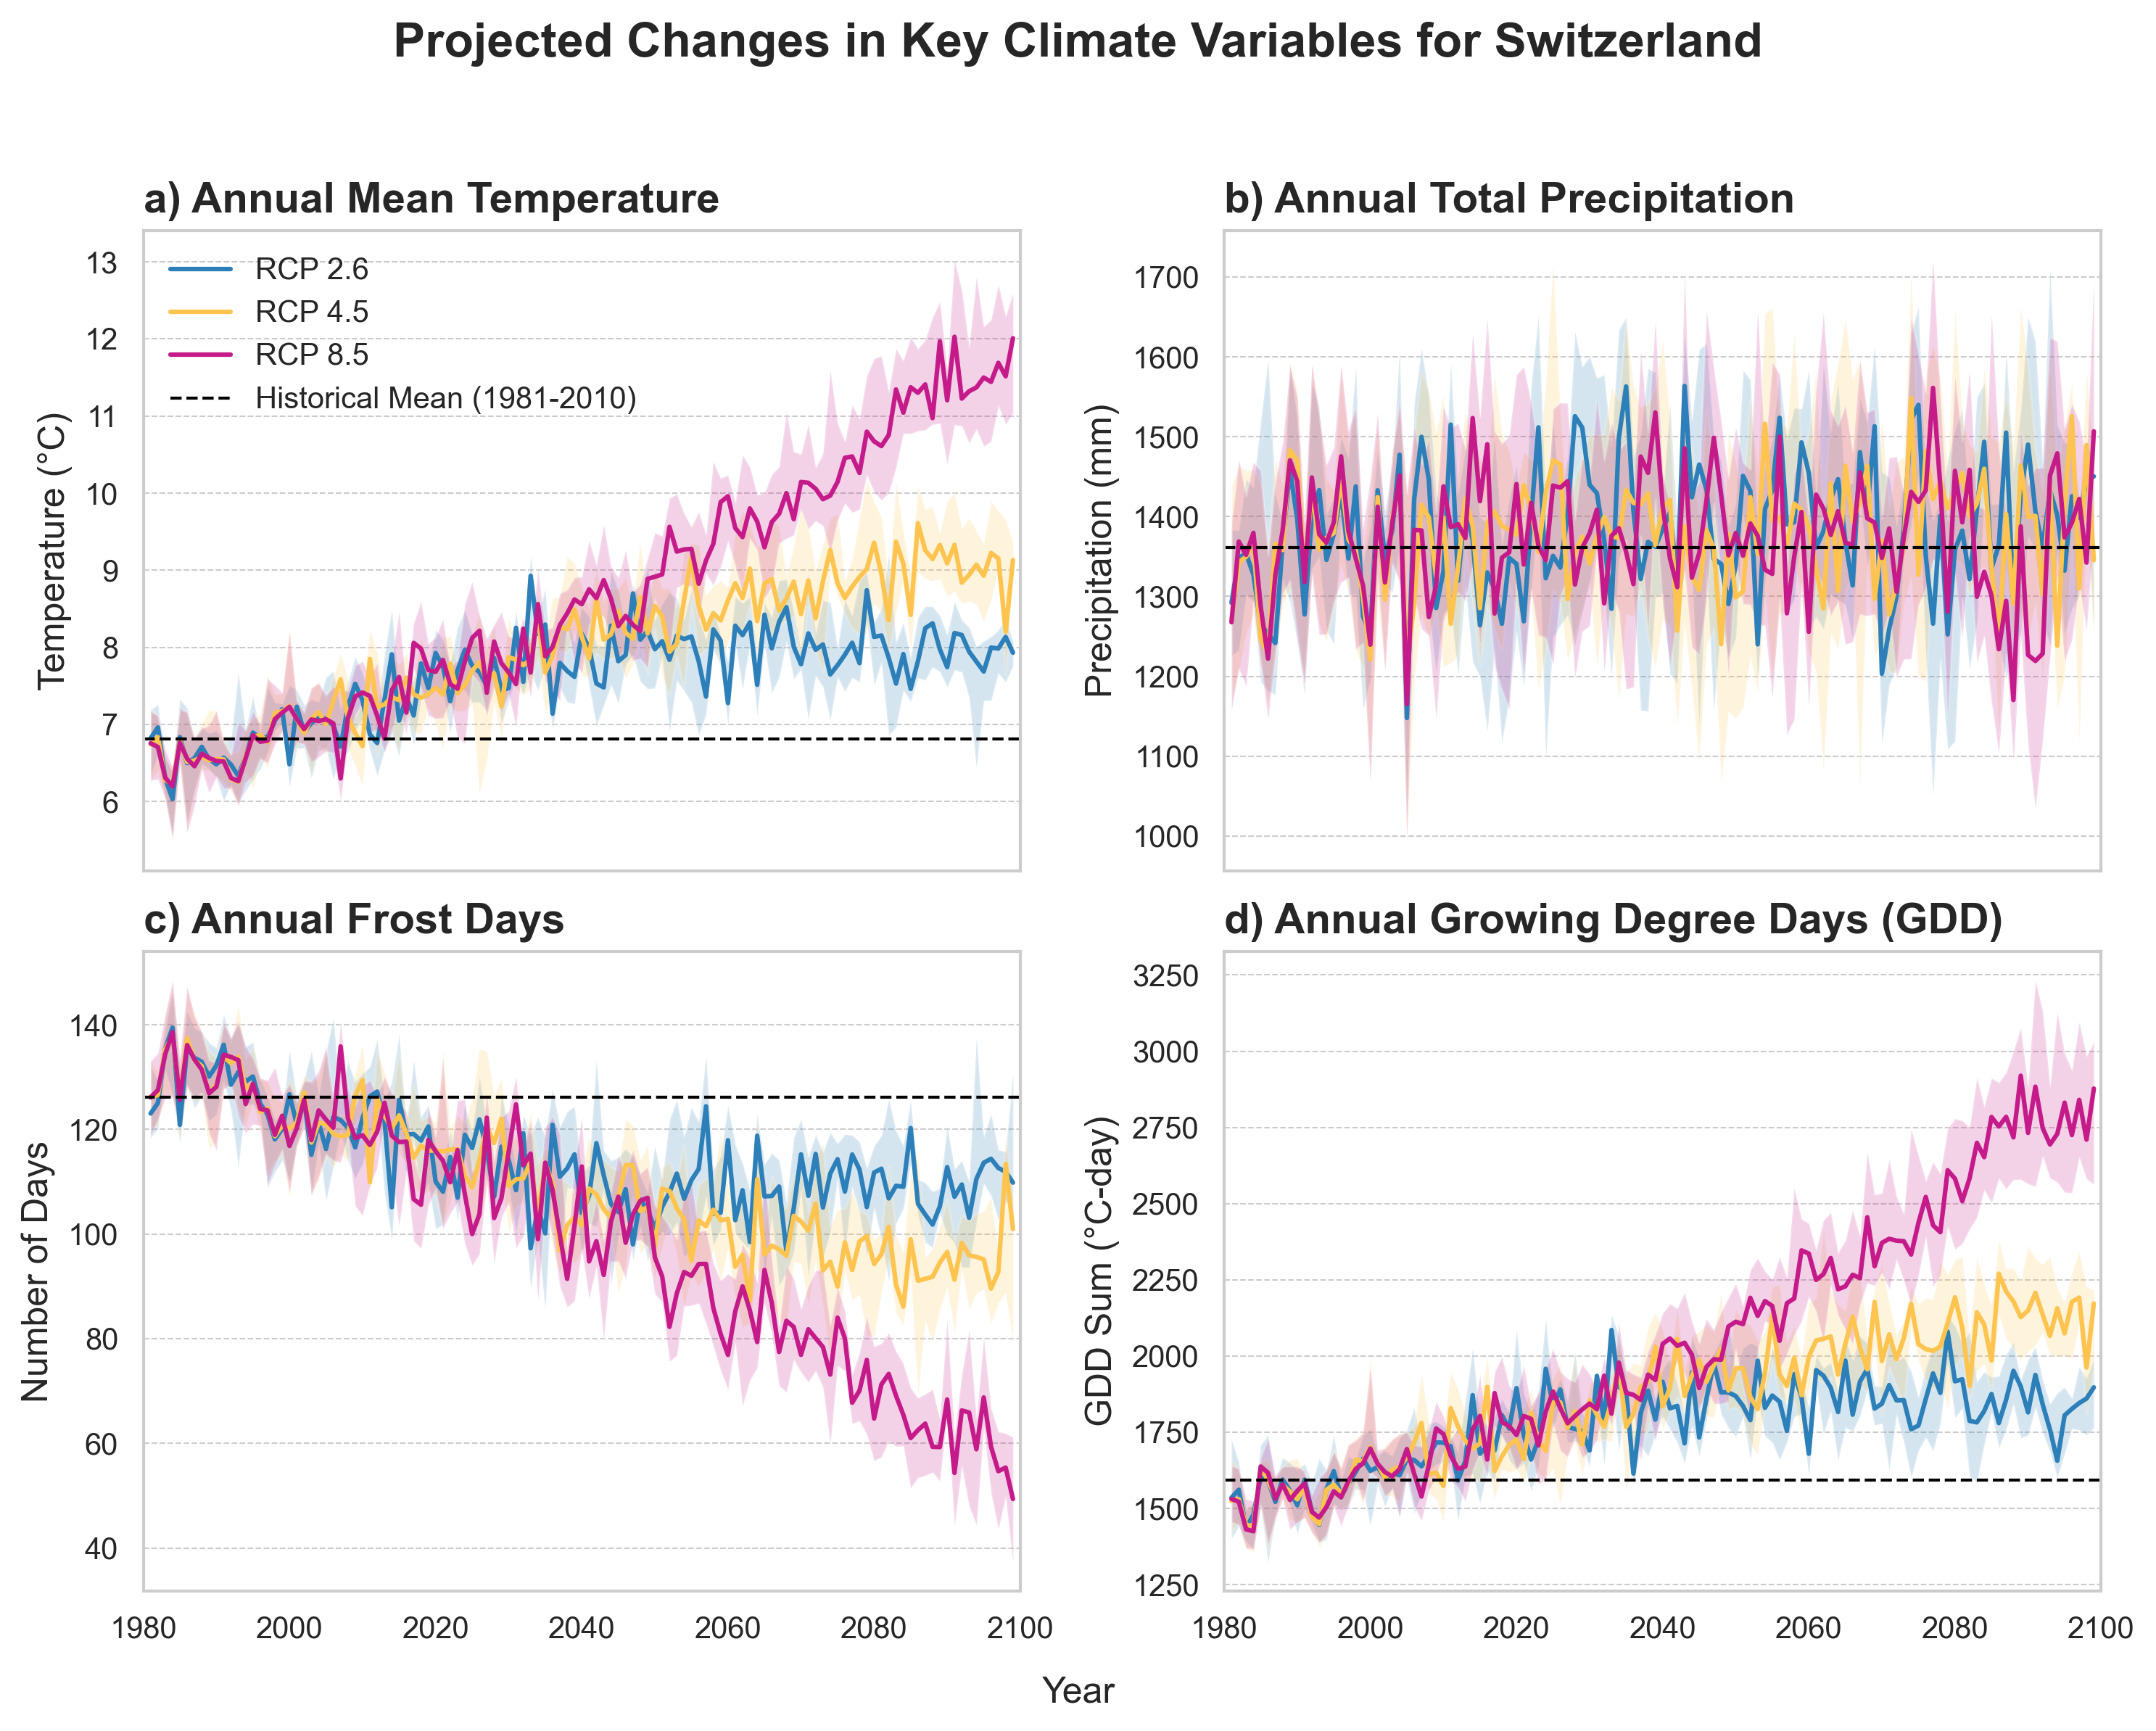

In [3]:
def plot_timeseries_with_uncertainty(df, variable, title, ylabel, ax, show_legend=False):
    """
    Plots a professional time series with a percentile-based uncertainty band.
    """
    # First, average the variable for each simulation across all locations
    sim_avg = df.groupby(['year', 'rcp', 'simulation'])[variable].mean().reset_index()
    
    # Next, calculate the median (p50) and percentiles (p25, p75) across simulations for each year and rcp
    summary_df = sim_avg.groupby(['year', 'rcp'])[variable].agg(
        median=np.median, 
        p25=lambda x: np.percentile(x, 25),
        p75=lambda x: np.percentile(x, 75)
    ).reset_index()
    
    # Plot for each RCP scenario
    for rcp_scenario in rcp_order:
        plot_data = summary_df[summary_df['rcp'] == rcp_scenario]
        ax.plot(plot_data['year'], plot_data['median'], 
                label=rcp_scenario, color=rcp_palette[rcp_scenario], linewidth=1.5)
        ax.fill_between(plot_data['year'], plot_data['p25'], plot_data['p75'], 
                        color=rcp_palette[rcp_scenario], alpha=0.2, edgecolor=None)

    # Historical baseline (1981-2010)
    hist_avg = df[df['year'].between(1981, 2010)][variable].mean()
    ax.axhline(hist_avg, color='black', linestyle='--', linewidth=1, label='Historical Mean (1981-2010)')

    ax.set_title(title, loc='left', weight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlim(1980, 2100)
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
    ax.grid(False, which='major', axis='x')
    
    if show_legend:
        ax.legend(frameon=False, loc='upper left')

# --- Create the multi-panel figure ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
fig.suptitle('Projected Changes in Key Climate Variables for Switzerland', fontsize=16, weight='bold', y=0.98)

# Panel (a): Mean Temperature
plot_timeseries_with_uncertainty(data, 'tas_mean', 'a) Annual Mean Temperature', 'Temperature (°C)', axes[0, 0], show_legend=True)

# Panel (b): Total Precipitation
plot_timeseries_with_uncertainty(data, 'pr_sum', 'b) Annual Total Precipitation', 'Precipitation (mm)', axes[0, 1])

# Panel (c): Frost Days
plot_timeseries_with_uncertainty(data, 'frost_days_count', 'c) Annual Frost Days', 'Number of Days', axes[1, 0])

# Panel (d): Growing Degree Days
plot_timeseries_with_uncertainty(data, 'gdd_sum', 'd) Annual Growing Degree Days (GDD)', 'GDD Sum (°C-day)', axes[1, 1])

# Common X-axis label
fig.text(0.5, 0.02, 'Year', ha='center', va='center', fontsize=12)

# Adjust layout and save
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
plt.savefig(OUTPUT_FILE_PATH, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nMap saved to {OUTPUT_FILE_PATH}")

plt.show()